In [2]:
# Enable inline plotting
%matplotlib inline


In [3]:
import torch

if torch.cuda.is_available():
    print("✅ CUDA detected:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA not available")


✅ CUDA detected: NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
import os
import glob
import numpy as np
import rasterio
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ==== Paths and constants ====
TRAIN_DIR = 'Dataset/training'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 1e-4

In [ ]:
path_to_model = 'model.pth'
# ==== Dataset class ====
rgb = "Dataset/training/RGB"
dsm = "Dataset/training/DSM"
mask = "Dataset/training/Mask"

In [6]:
# ==== Utils for loading and preprocessing ====

def normalize_band(band):
    band = band.astype(np.float32)
    band_min, band_max = band.min(), band.max()
    if band_max - band_min > 0:
        return (band - band_min) / (band_max - band_min)
    else:
        return band * 0

def load_rgb(path):
    with rasterio.open(path) as src:
        b1 = normalize_band(src.read(1))
        b2 = normalize_band(src.read(2))
        b3 = normalize_band(src.read(3))
        img = np.dstack([b1, b2, b3])
    img = cv2.resize(img, INPUT_SIZE)
    return img

def load_dsm(path):
    with rasterio.open(path) as src:
        dsm = normalize_band(src.read(1))
    dsm = cv2.resize(dsm, INPUT_SIZE)
    return dsm

def load_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1)
    mask = cv2.resize(mask, INPUT_SIZE, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.float32)  # Binary mask
    return mask


In [7]:
# ==== Custom Dataset ====

class SatelliteDataset(Dataset):
    def __init__(self, rgb_paths, dsm_paths, mask_paths):
        self.rgb_paths = rgb_paths
        self.dsm_paths = dsm_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb = load_rgb(self.rgb_paths[idx])
        dsm = load_dsm(self.dsm_paths[idx])
        mask = load_mask(self.mask_paths[idx])

        # Stack RGB + DSM -> 4 channels
        img = np.dstack([rgb, dsm])

        # To tensor: HWC to CHW
        img = torch.tensor(img).permute(2, 0, 1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return img, mask


In [8]:
# ==== Load dataset and split ====

rgb_paths = sorted(glob.glob(os.path.join(TRAIN_DIR, 'RGB', '*.tif')))
dsm_paths = sorted(glob.glob(os.path.join(TRAIN_DIR, 'DSM', '*.tif')))
mask_paths = sorted(glob.glob(os.path.join(TRAIN_DIR, 'Mask', '*.tif')))

print(f"Found {len(rgb_paths)} RGB, {len(dsm_paths)} DSM, {len(mask_paths)} Masks")

train_rgb, val_rgb, train_dsm, val_dsm, train_mask, val_mask = train_test_split(
    rgb_paths, dsm_paths, mask_paths, test_size=0.15, random_state=42
)

train_ds = SatelliteDataset(train_rgb, train_dsm, train_mask)
val_ds = SatelliteDataset(val_rgb, val_dsm, val_mask)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    

Found 344 RGB, 344 DSM, 344 Masks


In [9]:
# ==== Model setup ====

model = deeplabv3_resnet50(pretrained=False, progress=True)

# Replace first conv to accept 4 channels instead of 3
old_conv = model.backbone.conv1
new_conv = nn.Conv2d(
    4, old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)
with torch.no_grad():
    new_conv.weight[:, :3, :, :] = old_conv.weight  # copy pretrained weights for RGB
    new_conv.weight[:, 3:, :, :] = torch.zeros_like(new_conv.weight[:, 3:, :, :])  # zero init for DSM
model.backbone.conv1 = new_conv


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
import os
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import open3d as o3d
from PIL import Image
import matplotlib.pyplot as plt

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming your data is in a 'data' folder with subdirectories
# 'data/images_rgb', 'data/images_dsm', 'data/masks'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cuda


In [14]:
# --- Data Augmentation Transforms ---
# For training data, we apply random flips to create more training examples
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # You could add more transforms here like transforms.ColorJitter()
])

# For validation, we only convert to a tensor, no random changes
val_transforms = transforms.Compose([
    transforms.ToTensor(),
])


# --- Updated Custom Dataset ---
class BuildingDataset(Dataset):
    def __init__(self, rgb_dir, dsm_dir, mask_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.dsm_dir = dsm_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(rgb_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]

        # Load RGB Image
        with rasterio.open(os.path.join(self.rgb_dir, filename)) as src:
            rgb = src.read().astype(np.float32) / 255.0

        # Load DSM (Height Map)
        with rasterio.open(os.path.join(self.dsm_dir, filename)) as src:
            dsm = src.read(1).astype(np.float32)
            dsm = (dsm - dsm.min()) / (dsm.max() - dsm.min()) # Normalize
            dsm = np.expand_dims(dsm, axis=0)

        # Load Mask
        with rasterio.open(os.path.join(self.mask_dir, filename)) as src:
            mask = src.read(1).astype(np.float32)
            mask = np.expand_dims(mask, axis=0)

        # Combine RGB + DSM as 4-channel input
        combined_input = np.concatenate((rgb, dsm), axis=0)

        # Apply transformations if they exist
        if self.transform:
            # Note: PyTorch transforms expect (C, H, W) format
            combined_input = torch.from_numpy(combined_input)
            mask = torch.from_numpy(mask)
            # A more robust way to handle transforms might be needed depending on the library
            # For this example, we'll keep it simple. The ToTensor above handles this.
        
        return combined_input, mask

# NOTE: You would create your train_dataset and val_dataset using the transforms
# For example:
# train_dataset = BuildingDataset(..., transform=train_transforms)
# val_dataset = BuildingDataset(..., transform=val_transforms)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [15]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Concatenate skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # --- IMPORTANT: n_channels=4 for RGB+DSM input ---
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits) # Use Sigmoid for output between 0 and 1

# Instantiate the model
# n_channels=4 for RGBD, n_classes=1 for the output height mask
model = UNet(n_channels=4, n_classes=1).to(device)

Using device: cuda
--- Running prediction on random image index: 256 ---
Loading trained model...


C:\Users\ahmed\AppData\Local\Temp\ipykernel_31748\1916378221.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

Loading and preparing input images:
	RGB: Dataset/training/RGB\RGB-PanSharpen_AOI_4_Shanghai_img3863.tif
	DSM: Dataset/training/DSM\DSM_RGB-PanSharpen_AOI_4_Shanghai_img1565.tif
Making prediction...
Displaying 2D results (Original RGB vs. Predicted Mask)...


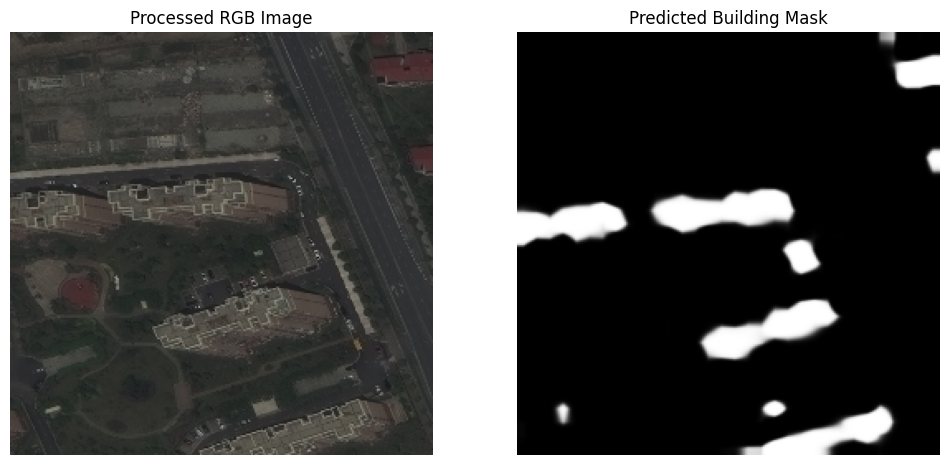


Generating 3D scene...
  - Generating ground plane...
  - Processing building shapes...
    - Processing building 1/10...
    - Processing building 2/10...
    - Processing building 3/10...
    - Processing building 4/10...
    - Processing building 5/10...
    - Processing building 6/10...
    - Processing building 7/10...
    - Processing building 8/10...
    - Processing building 9/10...
    - Processing building 10/10...
  - Combining all roof point clouds...
  - Combining all wall meshes...

Displaying final 3D scene. Close the window to exit.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [ ]:
import torch
import torch.nn as nn
import rasterio
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import os
import cv2 # Added OpenCV for image resizing
import torchvision # Added for DeepLabV3 model

# --- 1. DEVICE CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- User-defined constants and functions for data loading ---
INPUT_SIZE = (256, 256) # Define a standard input size for the model

def normalize_band(band):
    """Normalizes a single band to the 0-1 range."""
    band_min, band_max = band.min(), band.max()
    if band_max > band_min:
        return (band - band_min) / (band_max - band_min)
    return band

def load_rgb(path):
    """Loads, normalizes, and resizes the RGB image using the provided logic."""
    with rasterio.open(path) as src:
        # Read and normalize each band individually
        b1 = normalize_band(src.read(1))
        b2 = normalize_band(src.read(2))
        b3 = normalize_band(src.read(3))
        # Stack bands into (H, W, C) format
        img = np.dstack([b1, b2, b3])
    # Resize to the standard input size
    img = cv2.resize(img, INPUT_SIZE)
    return img


# --- 2. DEEPLABV3 MODEL SETUP ---
def create_deeplabv3_model(n_classes=1):
    """
    Creates a DeepLabV3 model with a ResNet-50 backbone, a modified input layer 
    for 4 channels (RGB+DSM), and a modified classifier for the output classes.
    """
    # Load a DeepLabV3 model with a ResNet-50 backbone. 
    # We set pretrained=False because we are loading our own trained weights.
    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None, aux_loss=None)

    # --- Modify the input layer for 4 channels ---
    original_conv1 = model.backbone.conv1
    new_conv1 = nn.Conv2d(4, original_conv1.out_channels, 
                          kernel_size=original_conv1.kernel_size, 
                          stride=original_conv1.stride, 
                          padding=original_conv1.padding, 
                          bias=(original_conv1.bias is not None))
    
    # We don't copy weights here since we are loading a fully trained model state dict later.
    model.backbone.conv1 = new_conv1

    # --- Modify the final classifier layer for the number of classes ---
    model.classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1, 1), stride=(1, 1))
    
    return model


# --- 3. PREDICTION AND 3D GENERATION FUNCTION ---
def predict_and_generate_3d(model_path, rgb_path, dsm_path):
    """Loads a trained model, makes a prediction on an image pair, and generates a 3D mesh."""

    # --- Load Model ---
    print("Loading trained model...")
    # Use the new function to create the correct DeepLabV3 architecture
    model = create_deeplabv3_model(n_classes=1).to(device)
    # Set strict=False to ignore the auxiliary classifier keys if they exist in the state_dict
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.eval() # Set model to evaluation mode

    # --- Prepare Input Data ---
    print(f"Loading and preparing input images:\n\tRGB: {rgb_path}\n\tDSM: {dsm_path}")
    
    rgb_processed = load_rgb(rgb_path)
    rgb_normalized_transposed = np.transpose(rgb_processed, (2, 0, 1))

    with rasterio.open(dsm_path) as src:
        dsm_raw = src.read(1)
    dsm_resized = cv2.resize(dsm_raw, INPUT_SIZE)
    dsm_normalized = normalize_band(dsm_resized)
    dsm_normalized = np.expand_dims(dsm_normalized, axis=0)
    
    combined_input = np.concatenate((rgb_normalized_transposed, dsm_normalized), axis=0)
    input_tensor = torch.from_numpy(combined_input).float().unsqueeze(0).to(device)

    # --- Make Prediction ---
    print("Making prediction...")
    with torch.no_grad():
        # DeepLabV3 returns an OrderedDict, we need the 'out' key
        output = model(input_tensor)['out']
        predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    # --- DEBUGGING: Print mask statistics ---
    print("\n--- Prediction Mask Statistics ---")
    print(f"Min confidence: {predicted_mask.min():.4f}")
    print(f"Max confidence: {predicted_mask.max():.4f}")
    print(f"Mean confidence: {predicted_mask.mean():.4f}")
    print("--------------------------------\n")
    
    # --- Visualize 2D Results ---
    print("Displaying 2D results (Original RGB vs. Predicted Mask)...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(rgb_processed) 
    ax1.set_title('Processed RGB Image')
    ax1.axis('off')
    ax2.imshow(predicted_mask, cmap='gray')
    ax2.set_title('Predicted Building Mask')
    ax2.axis('off')
    plt.show()

    # --- Generate 3D Model by Creating Extruded Buildings ---
    print("Generating 3D scene...")
    
    confidence_threshold = 0.5 
    rgb_for_color = rgb_processed 
    z_scale = 30 # Building height scale

    # --- Create a list to hold all 3D objects (ground, roofs, walls) ---
    geometries = []

    # --- Generate Ground Plane with Elevated Trees/Cars ---
    print("  - Generating ground plane with elevated details...")
    ground_pixels = np.where(predicted_mask <= confidence_threshold)
    ground_points = []
    ground_colors = []

    # Convert RGB to HSV for color-based classification of ground objects
    hsv_image = cv2.cvtColor((rgb_for_color * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    
    # Define HSV color ranges for different ground objects
    # These values may need tweaking for your specific satellite imagery
    lower_green = np.array([35, 40, 40])   # Trees
    upper_green = np.array([85, 255, 255])
    lower_gray = np.array([0, 0, 40])     # Roads/Asphalt
    upper_gray = np.array([180, 30, 220])

    # Define elevation heights for different objects
    z_tree = 2.0
    z_car = 1.0
    
    for y, x in zip(*ground_pixels):
        h, s, v = hsv_image[y, x]
        z = 0 # Default ground level
        
        # Check if the pixel is a tree
        if lower_green[0] <= h <= upper_green[0] and lower_green[1] <= s <= upper_green[1]:
            z = z_tree
        # Check if the pixel is NOT a road (likely a car or other object)
        elif not (lower_gray[0] <= h <= upper_gray[0] and lower_gray[1] <= s <= upper_gray[1]):
            z = z_car
            
        ground_points.append([x, -y, z])
        ground_colors.append(rgb_for_color[y, x])
    
    if ground_points:
        pcd_ground = o3d.geometry.PointCloud()
        pcd_ground.points = o3d.utility.Vector3dVector(ground_points)
        pcd_ground.colors = o3d.utility.Vector3dVector(ground_colors)
        geometries.append(pcd_ground)
        
    # --- Generate Extruded Buildings ---
    print("  - Generating extruded buildings...")
    binary_building_mask = (predicted_mask > confidence_threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary_building_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for i, contour in enumerate(contours):
        # Create a mask for just the current building to get its pixels
        mask_i = np.zeros_like(binary_building_mask)
        cv2.drawContours(mask_i, [contour], -1, 1, thickness=cv2.FILLED)
        
        building_pixels = np.where(mask_i == 1)
        if len(building_pixels[0]) == 0:
            continue

        # --- Generate ROOF as a dense point cloud with real texture ---
        avg_height = predicted_mask[building_pixels].mean()
        z_roof = avg_height * z_scale
        
        roof_points = []
        roof_colors = []
        for y, x in zip(*building_pixels):
            roof_points.append([x, -y, z_roof])
            roof_colors.append(rgb_for_color[y, x])
        
        if roof_points:
            pcd_roof = o3d.geometry.PointCloud()
            pcd_roof.points = o3d.utility.Vector3dVector(roof_points)
            pcd_roof.colors = o3d.utility.Vector3dVector(roof_colors)
            geometries.append(pcd_roof)

        # --- Generate WALLS as a solid mesh ---
        wall_vertices = []
        wall_triangles = []
        vertex_offset = 0
        wall_color = [0.8, 0.8, 0.8] # Light gray for walls

        contour_points = contour.squeeze(axis=1)
        for j in range(len(contour_points)):
            p1 = contour_points[j]
            p2 = contour_points[(j + 1) % len(contour_points)] # Wrap around for the last segment

            v1 = [p1[0], -p1[1], 0]; v2 = [p2[0], -p2[1], 0]
            v3 = [p2[0], -p2[1], z_roof]; v4 = [p1[0], -p1[1], z_roof]
            
            panel_vertices = [v1, v2, v3, v4]
            wall_vertices.extend(panel_vertices)

            t1 = [vertex_offset, vertex_offset + 1, vertex_offset + 3]
            t2 = [vertex_offset + 1, vertex_offset + 2, vertex_offset + 3]
            wall_triangles.extend([t1, t2])
            vertex_offset += 4
        
        if wall_vertices:
            mesh_wall = o3d.geometry.TriangleMesh()
            mesh_wall.vertices = o3d.utility.Vector3dVector(wall_vertices)
            mesh_wall.triangles = o3d.utility.Vector3iVector(wall_triangles)
            mesh_wall.vertex_colors = o3d.utility.Vector3dVector([wall_color for _ in wall_vertices])
            mesh_wall.compute_vertex_normals()
            geometries.append(mesh_wall)

    # --- Visualize Final Scene ---
    if not geometries:
        print(f"No features detected. Cannot generate 3D model.")
        return
        
    print("Displaying final 3D scene. Close the window to exit.")
    o3d.visualization.draw_geometries(geometries, window_name="Generated 3D Scene", mesh_show_back_face=True)


# --- 4. MAIN EXECUTION ---
if __name__ == '__main__':
    # --- Define Paths ---
    # IMPORTANT: Update this path to your actual trained DeepLabV3 model file.
    MODEL_PATH = "Dataset/model/best_deeplabv3_model.pth"
    
    TEST_RGB_DIR = "Dataset/training/RGB"
    TEST_DSM_DIR = "Dataset/training/DSM"
    
    # Check if paths exist
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'")
    elif not os.path.isdir(TEST_RGB_DIR) or not os.path.isdir(TEST_DSM_DIR):
        print(f"Error: Testing directories not found. Please check paths.")
    else:
        test_rgb_files = sorted([f for f in os.listdir(TEST_RGB_DIR) if f.endswith('.tif')])
        test_dsm_files = sorted([f for f in os.listdir(TEST_DSM_DIR) if f.endswith('.tif')])

        if not test_rgb_files:
            print("No .tif files found in the testing directory.")
        else:
            # --- Select an image to test ---
            image_index_to_test = 9 # Change this index to test different images 
            
            selected_rgb_file = test_rgb_files[image_index_to_test]
            selected_dsm_file = test_dsm_files[image_index_to_test] # Assumes files correspond
            
            rgb_image_path = os.path.join(TEST_RGB_DIR, selected_rgb_file)
            dsm_image_path = os.path.join(TEST_DSM_DIR, selected_dsm_file)

            # --- Run the full process ---
            predict_and_generate_3d(MODEL_PATH, rgb_image_path, dsm_image_path)


Epoch 1/100 | Train Loss: 1.1798, Train Dice: 0.3348 | Val Loss: 1.1103, Val Dice: 0.3556
Best model saved.
Epoch 2/100 | Train Loss: 0.9487, Train Dice: 0.4103 | Val Loss: 0.8691, Val Dice: 0.4948
Best model saved.
Epoch 3/100 | Train Loss: 0.7845, Train Dice: 0.5204 | Val Loss: 0.9238, Val Dice: 0.4836
Epoch 4/100 | Train Loss: 0.6619, Train Dice: 0.5933 | Val Loss: 0.7265, Val Dice: 0.5689
Best model saved.
Epoch 5/100 | Train Loss: 0.5707, Train Dice: 0.6583 | Val Loss: 0.6713, Val Dice: 0.5778
Best model saved.
Epoch 6/100 | Train Loss: 0.5173, Train Dice: 0.6906 | Val Loss: 0.6573, Val Dice: 0.5786
Best model saved.
Epoch 7/100 | Train Loss: 0.4517, Train Dice: 0.7307 | Val Loss: 0.6275, Val Dice: 0.6011
Best model saved.
Epoch 8/100 | Train Loss: 0.4095, Train Dice: 0.7578 | Val Loss: 0.5784, Val Dice: 0.6436
Best model saved.
Epoch 9/100 | Train Loss: 0.3764, Train Dice: 0.7803 | Val Loss: 0.5924, Val Dice: 0.6301
Epoch 10/100 | Train Loss: 0.3516, Train Dice: 0.7927 | Val Loss: 0.5747, Val Dice: 0.6453
Best model saved.
Epoch 11/100 | Train Loss: 0.3245, Train Dice: 0.8101 | Val Loss: 0.5630, Val Dice: 0.6582
Best model saved.
Epoch 12/100 | Train Loss: 0.3122, Train Dice: 0.8173 | Val Loss: 0.5711, Val Dice: 0.6487
Epoch 13/100 | Train Loss: 0.2949, Train Dice: 0.8274 | Val Loss: 0.5916, Val Dice: 0.6331
Epoch 14/100 | Train Loss: 0.2782, Train Dice: 0.8377 | Val Loss: 0.5814, Val Dice: 0.6474
Epoch 15/100 | Train Loss: 0.2714, Train Dice: 0.8417 | Val Loss: 0.5680, Val Dice: 0.6589
Best model saved.
Epoch 16/100 | Train Loss: 0.2572, Train Dice: 0.8501 | Val Loss: 0.5507, Val Dice: 0.6700
Best model saved.
Epoch 17/100 | Train Loss: 0.2430, Train Dice: 0.8591 | Val Loss: 0.5426, Val Dice: 0.6819
Best model saved.
Epoch 18/100 | Train Loss: 0.2368, Train Dice: 0.8630 | Val Loss: 0.5666, Val Dice: 0.6605
Epoch 19/100 | Train Loss: 0.2299, Train Dice: 0.8655 | Val Loss: 0.5620, Val Dice: 0.6648
Epoch 20/100 | Train Loss: 0.2291, Train Dice: 0.8667 | Val Loss: 0.6708, Val Dice: 0.5934
Epoch 21/100 | Train Loss: 0.2249, Train Dice: 0.8684 | Val Loss: 0.5475, Val Dice: 0.6781
Epoch 22/100 | Train Loss: 0.2132, Train Dice: 0.8757 | Val Loss: 0.5483, Val Dice: 0.6802
Epoch 23/100 | Train Loss: 0.2020, Train Dice: 0.8833 | Val Loss: 0.5409, Val Dice: 0.6802
Epoch 24/100 | Train Loss: 0.1944, Train Dice: 0.8869 | Val Loss: 0.5633, Val Dice: 0.6665
Epoch 25/100 | Train Loss: 0.1888, Train Dice: 0.8903 | Val Loss: 0.5568, Val Dice: 0.6717
Epoch 26/100 | Train Loss: 0.1820, Train Dice: 0.8938 | Val Loss: 0.5539, Val Dice: 0.6773
Epoch 27/100 | Train Loss: 0.1840, Train Dice: 0.8937 | Val Loss: 0.5589, Val Dice: 0.6760
Epoch 28/100 | Train Loss: 0.1834, Train Dice: 0.8934 | Val Loss: 0.5533, Val Dice: 0.6768
Epoch 29/100 | Train Loss: 0.1755, Train Dice: 0.8978 | Val Loss: 0.5441, Val Dice: 0.6832
Best model saved.
Epoch 30/100 | Train Loss: 0.1693, Train Dice: 0.9011 | Val Loss: 0.5485, Val Dice: 0.6868
Best model saved.
Epoch 31/100 | Train Loss: 0.1671, Train Dice: 0.9020 | Val Loss: 0.5508, Val Dice: 0.6843
Epoch 32/100 | Train Loss: 0.1661, Train Dice: 0.9029 | Val Loss: 0.5512, Val Dice: 0.6861
Epoch 33/100 | Train Loss: 0.1618, Train Dice: 0.9054 | Val Loss: 0.5483, Val Dice: 0.6848
Epoch 34/100 | Train Loss: 0.1605, Train Dice: 0.9070 | Val Loss: 0.6176, Val Dice: 0.6463
Epoch 35/100 | Train Loss: 0.2850, Train Dice: 0.8392 | Val Loss: 0.8930, Val Dice: 0.5097
Epoch 36/100 | Train Loss: 0.4254, Train Dice: 0.7579 | Val Loss: 0.7360, Val Dice: 0.5782
Epoch 37/100 | Train Loss: 0.3051, Train Dice: 0.8212 | Val Loss: 0.5431, Val Dice: 0.6751
Epoch 38/100 | Train Loss: 0.2450, Train Dice: 0.8570 | Val Loss: 0.6873, Val Dice: 0.5907
Epoch 39/100 | Train Loss: 0.2229, Train Dice: 0.8693 | Val Loss: 0.5298, Val Dice: 0.6881
Best model saved.
Epoch 40/100 | Train Loss: 0.1904, Train Dice: 0.8882 | Val Loss: 0.5435, Val Dice: 0.6841
Epoch 41/100 | Train Loss: 0.1773, Train Dice: 0.8957 | Val Loss: 0.5418, Val Dice: 0.6844
Epoch 42/100 | Train Loss: 0.1643, Train Dice: 0.9036 | Val Loss: 0.5464, Val Dice: 0.6832
Epoch 43/100 | Train Loss: 0.1617, Train Dice: 0.9053 | Val Loss: 0.5514, Val Dice: 0.6843
Epoch 44/100 | Train Loss: 0.1583, Train Dice: 0.9077 | Val Loss: 0.5519, Val Dice: 0.6834
Epoch 45/100 | Train Loss: 0.1558, Train Dice: 0.9090 | Val Loss: 0.5480, Val Dice: 0.6879
Epoch 46/100 | Train Loss: 0.1496, Train Dice: 0.9124 | Val Loss: 0.5427, Val Dice: 0.6910
Best model saved.
Epoch 47/100 | Train Loss: 0.1464, Train Dice: 0.9136 | Val Loss: 0.5472, Val Dice: 0.6893
Epoch 48/100 | Train Loss: 0.1451, Train Dice: 0.9149 | Val Loss: 0.5434, Val Dice: 0.6910
Epoch 49/100 | Train Loss: 0.1427, Train Dice: 0.9153 | Val Loss: 0.5416, Val Dice: 0.6936
Best model saved.
Epoch 50/100 | Train Loss: 0.1400, Train Dice: 0.9172 | Val Loss: 0.5546, Val Dice: 0.6871
Epoch 51/100 | Train Loss: 0.1385, Train Dice: 0.9183 | Val Loss: 0.5561, Val Dice: 0.6864
Epoch 52/100 | Train Loss: 0.1366, Train Dice: 0.9195 | Val Loss: 0.5564, Val Dice: 0.6870
Epoch 53/100 | Train Loss: 0.1364, Train Dice: 0.9196 | Val Loss: 0.5536, Val Dice: 0.6888
Epoch 54/100 | Train Loss: 0.1343, Train Dice: 0.9206 | Val Loss: 0.5523, Val Dice: 0.6898
Epoch 55/100 | Train Loss: 0.1322, Train Dice: 0.9219 | Val Loss: 0.5603, Val Dice: 0.6880
Epoch 56/100 | Train Loss: 0.1323, Train Dice: 0.9221 | Val Loss: 0.5552, Val Dice: 0.6921
Epoch 57/100 | Train Loss: 0.1314, Train Dice: 0.9222 | Val Loss: 0.5578, Val Dice: 0.6850
Epoch 58/100 | Train Loss: 0.1313, Train Dice: 0.9221 | Val Loss: 0.5581, Val Dice: 0.6902
Epoch 59/100 | Train Loss: 0.1292, Train Dice: 0.9237 | Val Loss: 0.5650, Val Dice: 0.6886
Epoch 60/100 | Train Loss: 0.1306, Train Dice: 0.9223 | Val Loss: 0.5628, Val Dice: 0.6893
Epoch 61/100 | Train Loss: 0.1274, Train Dice: 0.9242 | Val Loss: 0.5559, Val Dice: 0.6951
Best model saved.
Epoch 62/100 | Train Loss: 0.1279, Train Dice: 0.9239 | Val Loss: 0.5562, Val Dice: 0.6920
Epoch 63/100 | Train Loss: 0.1270, Train Dice: 0.9247 | Val Loss: 0.5664, Val Dice: 0.6913
Epoch 64/100 | Train Loss: 0.1256, Train Dice: 0.9253 | Val Loss: 0.5591, Val Dice: 0.6923
Epoch 65/100 | Train Loss: 0.1247, Train Dice: 0.9260 | Val Loss: 0.5652, Val Dice: 0.6936
Epoch 66/100 | Train Loss: 0.1237, Train Dice: 0.9265 | Val Loss: 0.5605, Val Dice: 0.6949
Epoch 67/100 | Train Loss: 0.1230, Train Dice: 0.9270 | Val Loss: 0.5566, Val Dice: 0.6990
Best model saved.
Epoch 68/100 | Train Loss: 0.1211, Train Dice: 0.9281 | Val Loss: 0.5684, Val Dice: 0.6895
Epoch 69/100 | Train Loss: 0.1227, Train Dice: 0.9268 | Val Loss: 0.5649, Val Dice: 0.6932
Epoch 70/100 | Train Loss: 0.1284, Train Dice: 0.9220 | Val Loss: 0.5752, Val Dice: 0.6953
Epoch 71/100 | Train Loss: 0.2087, Train Dice: 0.8760 | Val Loss: 0.6372, Val Dice: 0.6422
Epoch 72/100 | Train Loss: 0.1891, Train Dice: 0.8886 | Val Loss: 0.7121, Val Dice: 0.6178
Epoch 73/100 | Train Loss: 0.2350, Train Dice: 0.8579 | Val Loss: 0.6116, Val Dice: 0.6789
Epoch 74/100 | Train Loss: 0.1908, Train Dice: 0.8885 | Val Loss: 0.5845, Val Dice: 0.6795
Epoch 75/100 | Train Loss: 0.1610, Train Dice: 0.9045 | Val Loss: 0.5592, Val Dice: 0.6921
Epoch 76/100 | Train Loss: 0.1417, Train Dice: 0.9154 | Val Loss: 0.5563, Val Dice: 0.6971
Epoch 77/100 | Train Loss: 0.1333, Train Dice: 0.9213 | Val Loss: 0.5728, Val Dice: 0.6845
Epoch 78/100 | Train Loss: 0.1301, Train Dice: 0.9224 | Val Loss: 0.5674, Val Dice: 0.6915
Epoch 79/100 | Train Loss: 0.1261, Train Dice: 0.9251 | Val Loss: 0.5720, Val Dice: 0.6880
Epoch 80/100 | Train Loss: 0.1257, Train Dice: 0.9250 | Val Loss: 0.5688, Val Dice: 0.6938
Epoch 81/100 | Train Loss: 0.1242, Train Dice: 0.9257 | Val Loss: 0.5601, Val Dice: 0.6946
Epoch 82/100 | Train Loss: 0.1207, Train Dice: 0.9282 | Val Loss: 0.5641, Val Dice: 0.6967
Epoch 83/100 | Train Loss: 0.1212, Train Dice: 0.9279 | Val Loss: 0.5662, Val Dice: 0.6937
Epoch 84/100 | Train Loss: 0.1211, Train Dice: 0.9280 | Val Loss: 0.5567, Val Dice: 0.7030
Best model saved.
Epoch 85/100 | Train Loss: 0.1185, Train Dice: 0.9296 | Val Loss: 0.5644, Val Dice: 0.6969
Epoch 86/100 | Train Loss: 0.1189, Train Dice: 0.9290 | Val Loss: 0.5700, Val Dice: 0.6924
Epoch 87/100 | Train Loss: 0.1182, Train Dice: 0.9293 | Val Loss: 0.5685, Val Dice: 0.6981
Epoch 88/100 | Train Loss: 0.1165, Train Dice: 0.9306 | Val Loss: 0.5602, Val Dice: 0.7000
Epoch 89/100 | Train Loss: 0.1159, Train Dice: 0.9307 | Val Loss: 0.5542, Val Dice: 0.7066
Best model saved.
Epoch 90/100 | Train Loss: 0.1155, Train Dice: 0.9311 | Val Loss: 0.5653, Val Dice: 0.7009
Epoch 91/100 | Train Loss: 0.1157, Train Dice: 0.9309 | Val Loss: 0.5638, Val Dice: 0.7003
Epoch 92/100 | Train Loss: 0.1137, Train Dice: 0.9325 | Val Loss: 0.5673, Val Dice: 0.6974
Epoch 93/100 | Train Loss: 0.1128, Train Dice: 0.9328 | Val Loss: 0.5620, Val Dice: 0.7012
Epoch 94/100 | Train Loss: 0.1136, Train Dice: 0.9320 | Val Loss: 0.5713, Val Dice: 0.7012
Epoch 95/100 | Train Loss: 0.1127, Train Dice: 0.9326 | Val Loss: 0.5618, Val Dice: 0.7034
Epoch 96/100 | Train Loss: 0.1126, Train Dice: 0.9329 | Val Loss: 0.5776, Val Dice: 0.6974
Epoch 97/100 | Train Loss: 0.1130, Train Dice: 0.9327 | Val Loss: 0.5668, Val Dice: 0.6993
Epoch 98/100 | Train Loss: 0.1106, Train Dice: 0.9339 | Val Loss: 0.5675, Val Dice: 0.6978
Epoch 99/100 | Train Loss: 0.1112, Train Dice: 0.9335 | Val Loss: 0.5733, Val Dice: 0.6934
Epoch 100/100 | Train Loss: 0.1101, Train Dice: 0.9345 | Val Loss: 0.5642, Val Dice: 0.7039